## A/B Testing — A complete guide to statistical testing
### https://francescocasalegno.github.io/blog/post_abtesting.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import chi2_contingency, mannwhitneyu, norm, t, ttest_ind

%matplotlib inline

#### 1. Discrete Metrics
Let's consider first discrete metrics, e.g. click-though rate. We randomly show visitors one of two possible designs of an advertisement, and based on how many of them click on it we need to determine whether our data significantly contradict the hypothesis that the two designs are equivalently efficient.

In [2]:
np.random.seed(42)

x = np.random.binomial(n=1, p=0.6, size=15)
y = np.random.binomial(n=1, p=0.4, size=19)

_, (a, c) = np.unique(x, return_counts=True)
_, (b, d) = np.unique(y, return_counts=True)

df = pd.DataFrame(data=[[a, b], [c, d]], 
                 index=["click", "no click"], 
                 columns=["A", "B"])
m = df.values

print("- Observations:")
print(f"  - Version A: = {x}")
print(f"  - Version B: = {y}")
print("")
print("- Contingency table:")
display(df)

- Observations:
  - Version A: = [1 0 0 1 1 1 1 0 0 0 1 0 0 1 1]
  - Version B: = [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1]

- Contingency table:


,A,B
click,7,15
no click,8,4


#### 1.1 Fisher's exact test
Since we have a 2x2 contingency table we can use Fisher's exact test to compute an exact p-value and test our hypothesis.

In [3]:
def hypergeom(k, K, n, N):
    """Probability mass funciton of the hypergeometric distribution."""
    return binom(K, k) * binom(N-K, n-k) / binom(N, n)


def fisher_prob(m):
    """Probability of a given observed contingency table according to Fisher's exact test."""
    ((a, b), (c ,d)) = m
    k = a
    K = a+b
    n = a+c
    N = a+b+c+d
    return hypergeom(k, K, n, N)

def fisher_probs_histogram(m):
    """Computes prob mass function histogram accroding to Fisher's exact test."""
    neg_val = -min(m[0,0], m[1,1])
    pos_val = min(m[1,0], m[1,0])
    probs = []
    for k in range(neg_val, pos_val+1):
        m1 = m + np.array([[1, -1], [-1, 1]]) * k
        probs.append(fisher_prob(m1))
    return probs

- Fisher's exact test: p-val = 7.5%


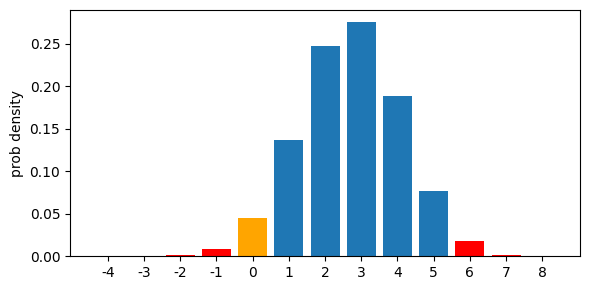

In [5]:
bars_h = np.array(fisher_probs_histogram(m))

f, ax = plt.subplots(figsize=(6, 3))
ii = np.arange(len(bars_h))
ax.bar(ii, bars_h)
idxs = bars_h <= fisher_prob(m)
ax.bar(ii[idxs], bars_h[idxs], color='r')
ax.set_ylabel("prob density")
p_val = bars_h[idxs].sum()
neg_val = -min(m[0,0], m[1,1])
pos_val = min(m[1,0], m[1,0])
ax.bar(ii[-neg_val], bars_h[-neg_val], color='orange')

ax.set_xticks(ii)
ax.set_xticklabels(np.arange(neg_val, pos_val+1))
f.tight_layout()
print(f"- Fisher's exact test: p-val = {100*p_val:.1f}%")

#### 1.2 Pearson's chi-squared test
Fisher's exact test has the important advantage of computing exact p-values. But if we have a large sample size, it may be computationally inefficient. In this case, we can use Pearson's chi-squared test to compute an approximate p-value.

In [6]:
chi2_val, p_val = chi2_contingency(m, correction=False)[:2]

print("- Pearson's chi-squared t-test:")
print(f"   - χ2 value: {chi2_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")

- Pearson's chi-squared t-test:
   - χ2 value: 3.825
   - p-value: 5.1%


#### 2. Continuous metrics
Let's now consider the case of a continuous metrics, e.g. average revenue per user. We randomly show visitors of our website one of two possible layouts of products for sale, and based on how much revenue each user generated in a month we want to determine whether our data significantly contradict the hypothesis that the two website layouts are equivalently efficient.

- Observations:
  - Version A: = [200 150 250 350 150 150 350 250 150 250 150 150 200   0   0 100  50]
  - Version B: = [300 150 150 400 250 250 150 200 250 150 300 200 250 200]

- Distribution plot:


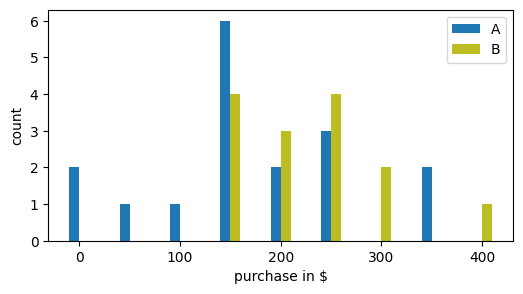

In [9]:
np.random.seed(42)

n_x, n_y = 17, 14

d1 = norm(loc=200, scale=100)
d2 = norm(loc=280, scale=90)

disc = 50
x = (d1.rvs(size=n_x) / disc).astype(int) * disc
y = (d2.rvs(size=n_y) / disc).astype(int) * disc


print("- Observations:")
print(f"  - Version A: = {x}")
print(f"  - Version B: = {y}")
print("")
print(f"- Distribution plot:")
f, ax = plt.subplots(figsize=(6, 3))
for i, (x_, l_, c_) in enumerate(zip([x, y], ["A", "B"], ["tab:blue", "tab:olive"])):
    v, c = np.unique(x_, return_counts=True)
    ax.bar(v-5+10*i, c, width=10, label=l_, color=c_)

ax.set_xlabel("purchase in $")
ax.set_ylabel("count")
ax.legend();

In [11]:
def plot_pval(distribution, t_val, xlims=(-5, 5), ylims=(0, 0.5)):
    xxx = np.linspace(*xlims, 1000)
    f, ax = plt.subplots(figsize=(4,3))
    ax.plot(xxx, distribution.pdf(xxx))
    ax.set_ylim(ylims)
    ax.vlines(t_val, 0, distribution.pdf(t_val), color='orange')
    ax.plot(t_val, distribution.pdf(t_val), 'o', color='orange')
    xp = xxx <= t_val
    ax.fill_between(xxx[xp], xxx[xp] * 0, distribution.pdf(xxx[xp]), color='r')
    xp = xxx >= -t_val
    ax.fill_between(xxx[xp], xxx[xp] * 0, distribution.pdf(xxx[xp]), color='r')
    ax.set_ylabel("prob denisty")
    f.tight_layout()
    return f, ax

##### 2.1 Z-test
##### The Z-test can be applied under the following assumptions.

* The observations are normally distributed (or the sample size is large).
* The sampling distributions have known variance σ_X and σ_Y.

Under the above assumptions, the Z-test relies on the observation that the following Z statistic has a standard normal distribution.


- Z-test:
   - z value: -1.697
   - p-value: 9.0%


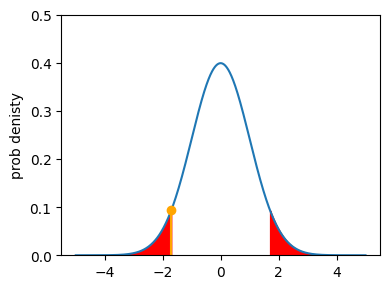

In [12]:
# Known standard deviations
s_x = 100
s_y = 90

# Z value
z_val = (x.mean() - y.mean()) / np.sqrt(s_x**2/n_x + s_y**2/n_y)

# Test statistic distribution under null hypothesis H0
stat_distrib = norm(loc=0, scale=1)

# p-value
p_val = stat_distrib.cdf(z_val) * 2

print("- Z-test:")
print(f"   - z value: {z_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);

#### 2.2 Student's t-test
In most cases, the variances of the sampling distributions are unknown, so that we need to estimate them. Student's t-test can then be applied under the following assumptions.

* The observations are normally distributed (or the sample size is large).
* The sampling distributions have "similar" variances σX ≈ σY.

Under the above assumptions, Student's t-test relies on the observation that the following t statistic has a Student's t distribution.

- Student's t-test:
   - nu: 29.000
   - t value: -1.789
   - p-value: 8.4%


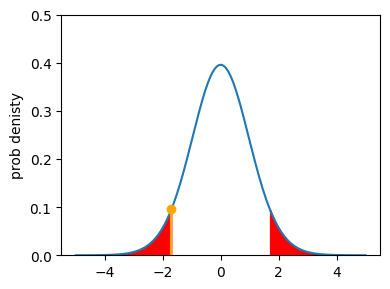

In [14]:
# Sample variances (w. Bessel correction)
s_x = np.sqrt(np.var(x, ddof=1))
s_y = np.sqrt(np.var(y, ddof=1))

# Pooled variance
s_p = np.sqrt(((n_x-1) * s_x**2 +
               (n_y-1) * s_y**2)
              / (n_x + n_y - 2))

# Test statistic distribution under null hypothesis H0
dofs = n_x + n_y - 2
stat_distrib = t(df=dofs, loc=0, scale=1)

# t value
t_val = (x.mean() - y.mean()) / (s_p * np.sqrt(1/n_x + 1/n_y))

# p-value
p_val = stat_distrib.cdf(t_val) * 2

print("- Student's t-test:")
print(f"   - nu: {dofs:.3f}")
print(f"   - t value: {t_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);

#### 2.3 Welch's t-test
In most cases Student's t test can be effectively applied with good results. However, it may rarely happen that its second assumption (similar variance of the sampling distributions) is violated. In that case, we cannot compute a pooled variance and rather than Student's t test we should use Welch's t-test.

This test operates under the same assumptions of Student's t-test but removes the requirement on the similar variances. Then, we can use a slightly different t statistic, which also has a Student's t distribution, but with a different number of degrees of freedom ν.

- Welch' t-test:
   - nu: 28.505
   - t value: -1.848
   - p-value: 7.5%


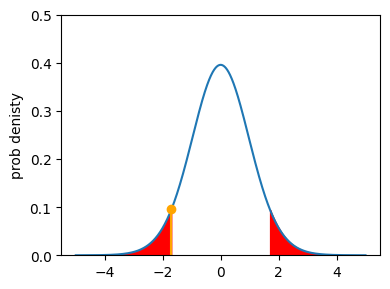

In [15]:
# Sample variances (w. Bessel correction)
s_x = np.sqrt(np.var(x, ddof=1))
s_y = np.sqrt(np.var(y, ddof=1))

# Denominator (not a pooled variance!)
s_d = np.sqrt(s_x**2/n_x + s_y**2/n_y)
    
    
# Test statistic distribution under null hypothesis H0
dofs = s_d**4 / ((s_x**2/n_x)**2/(n_x-1) +
                 (s_y**2/n_y)**2/(n_y-1))
stat_distrib = t(df=dofs, loc=0, scale=1)

# t value
t_val = (x.mean() - y.mean()) / s_d

# p-value
p_val = stat_distrib.cdf(t_val) * 2

print("- Welch' t-test:")
print(f"   - nu: {dofs:.3f}")
print(f"   - t value: {t_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);

#### 2.4 Mann-Whitney U test
This test makes the least assumptions about the nature of our observations, as it is fully nonparametric. The idea of Mann-Whitney U test is to compute the U statistic.

The values of this test statistic are tabulated, as the distribution can be computed under the null hypothesis that, for random samples X and Y from the two populations, the probability P(X < Y) is the same as P(X > Y).

In [16]:
mwu = mannwhitneyu(x, y, use_continuity=False, alternative="two-sided")

print("- Mann-Whitney U test:")
print(f"   - U value: {mwu.statistic:.3f}")
print(f"   - p-value: {mwu.pvalue*100:.1f}%")

- Mann-Whitney U test:
   - U value: 76.000
   - p-value: 8.0%


#### 3. Data distribution VS Stats distribution
Tests that rely on the assumption of normally distributed test statistics can also be applied if the original sampling distribution is highly non-normal!

Indeed, thanks to the Central Limit Theorem, the distribution of the test statistic is asymptotically normal as the sample size increases.

This is very useful in the common case of A/B tests that produce observations that are zero-inflated and/or multimodal.

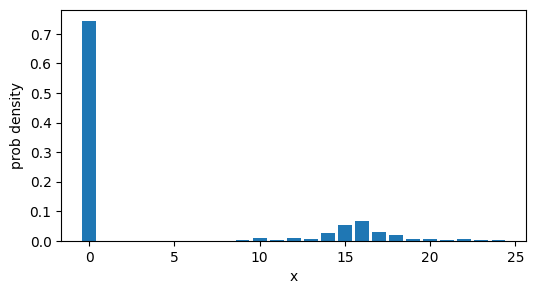

In [17]:
p = np.array([245, 0, 0, 0, 0, 0, 0, 0, 0,  1, 3, 1, 3, 2, 9, 18, 22, 10, 6, 2, 2, 1, 2, 1, 1])
a = np.arange(len(p))
p = p / p.sum()

f, ax = plt.subplots(figsize=(6, 3))
ax.bar(a, p)
ax.set_ylabel("prob density")
ax.set_xlabel("x");

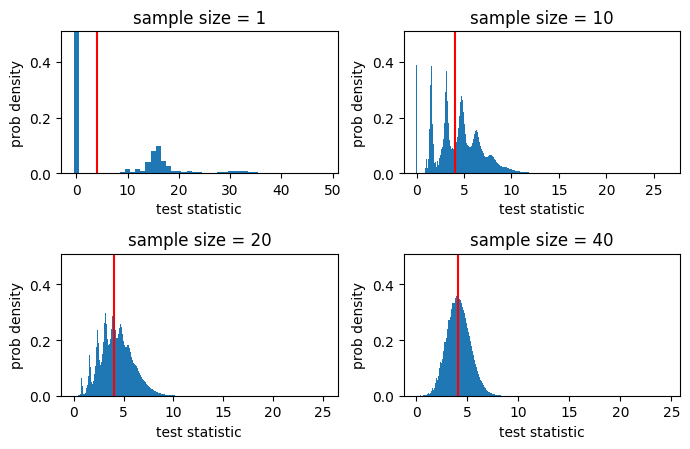

In [18]:
loc = (p*np.arange(len(p))).sum()

nn = [1, 10, 20, 40]
f, axx = plt.subplots(2, 2, figsize=(3.5*2, 2.3*2))    

for i, n in enumerate(nn):
    r, c = divmod(i, 2)        
    x = p
    ax = axx[r, c]
    for _ in range(n):
        x = np.convolve(x, p)

    ax.bar(np.arange(len(x))/n, x*n, width=1/n)
    ax.set_ylim([0, 0.51])
    ax.vlines(loc, 0, 0.51, 'r')
    ax.set_xlabel("test statistic")
    ax.set_ylabel("prob density")
    ax.set_title(f"sample size = {n}")

f.tight_layout()